In [1]:
import torch
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F

In [2]:
############# SYNTHETHIC DATA GENERATION #############
def generateData(las_x, las_y, det_x, det_y, numSpots, numPixels, 
                 visibility, numBins, plotDat, usePulse=False, pulseWidth=None, t=None):  
    ############
    # INPUTS: 
    #   visibility = numPixels x numSpots
    # OUTPUTS:
    #   hists = numPixels x numSpots x numBins tensor
    #   observations = numPixels x numBins tensor
    ############
    # constant variables
    c = 3E8   
    # compute histograms
    observations = torch.zeros((numPixels, numBins))
    hists = torch.zeros((numPixels, numSpots, numBins))
    for i in range(numPixels):
        for j in range(numSpots):
            x1 = las_x[j]; y1 = las_y[j]; x2 = det_x[i]; y2 = det_y[i]
            pathLen = (x1**2+y1**2)**0.5 + ((x2-x1)**2+(y2-y1))**0.5 + (x2**2+y2**2)**0.5
            t0 = pathLen / c
            if usePulse == False:
                if t is None:
                    raise Exception("t vector must be specified for rect pulses")
                a = rectangularPulse(t0, t0+pulseWidth, t)
            elif usePulse == True:
                t, a = pulse(t0, numBins)
                a = torch.squeeze(torch.tensor(a))
            hists[i, j, :] = a
            if visibility[i, j] == 1:
                observations[i, :] = observations[i, :] + a
    
    # plot data
    if plotData:
        # plot source and illumination
        plt.figure()
        plt.title('Setup')
        plt.plot(las_x, las_y, 'or')
        plt.plot(det_x, det_y, 'ob')
        plt.plot(0, 0, 'og')
        plt.xlim([-2, 2])
        plt.ylim([-0.5, 2])
        plt.legend(['laser', 'detector', 'iPhone'])
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')     
        # plot simulated histograms
        for i in range(numPixels):
            plt.figure()
            a = observations[i, :]
            plt.plot(t * 1E9, a)
            plt.xlabel('time (ns)')
            plt.ylabel('intensity (a.u)')
            plt.title('Observation at pixel ' + str(i+1))
            
    return observations, hists

In [3]:
###################### OPTIMIZATION FUNCTION #########################
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        super().__init__()
        # initialize weights with random numbers
        vis = torch.rand(numPixels, numSpots)
        
        # make weights torch parameters
        self.vis = nn.Parameter(vis, requires_grad = True)      
        
    def forward(self, hists):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
#         vis = self.vis
#         self.a, self.b, self.c = torch.tensor(0., requires_grad=True), 
#         torch.tensor(1., requires_grad=True), torch.tensor(0.5, requires_grad=True)
        vis = (self.vis - torch.min(self.vis)) / (torch.max(self.vis) - torch.min(self.vis))
        if False:
            relu = MyReLU.apply
            vis = relu(vis)
#         self.debug_v = torch.where(self.vis > 0.5, 1.0, 0.0)
#         print(self.debug_v.requires_grad)
#         self.debug_v = torch.where(self.vis > self.c, self.a, self.b)
#         self.debug_v.requires_grad = True
#         self.debug_v = self.vis
#         self.debug_v.retain_grad()
        obs = torch.sum(vis.unsqueeze(-1) * hists, 1)
        return obs

def training_loop(model, histograms, optimizer, thresh, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        preds = model(histograms)
        loss = F.mse_loss(preds, observations)#.sqrt()
        losses.append(loss.detach().numpy())  
        if loss < thresh:
            break
        loss.backward()
#         print(model.debug_v.grad.data)
        optimizer.step()
        optimizer.zero_grad()
    return losses

In [4]:
############# HELPER FUNCTIONS #####################

def rectangularPulse(t1, t2, t):
    if np.min(t) > t1 or np.max(t) < t2:
        raise Exception('check t bounds')
    return torch.tensor(((t >= t1) * (t <= t2)))

def pulse(t0, numBins):
    a = sio.loadmat('../pulseShapes_confidential.mat')
    a = a['pulseNP']
    numPad = numBins - len(a)
    a = np.pad(a, (0, numPad), 'edge'); a = a[:, 0]
    t = np.linspace(0, 100E-12 * (numBins-1), numBins)
    a = np.roll(a, round(t0 / 100E-12))
    return t, a


# Optimization Function
class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
#         return input.clamp(min=0.0)
        return torch.where(input > 0.5, 1.0, 0.0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        o = 0.49
        a = 0.5 - o; b = 0.5 + o
        m = 1/(b-a)
        input, = ctx.saved_tensors
#         grad_input = grad_output.clone()
#         grad_input[input < 0] = 0.0
#         print(type(torch.where((input < a or input > b), 0.0, m)))
        return grad_output * torch.where((input < a) & (input > b), 0.0, m)

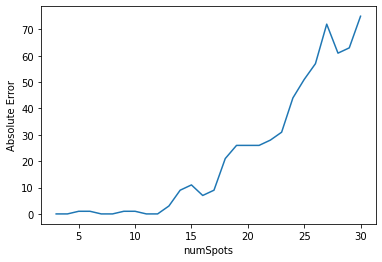

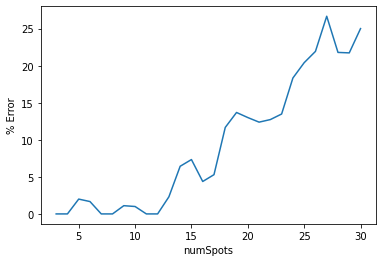

In [5]:
#### SWEEEP THROUGH NUMBER OF SPOTS AND SOLVE ####

# constant parameters
c = 3E8
    
# laser parameters
pulseWidth = 1E-9 # must be larger than detector resolution

# detector parameters
detectorRes = 100E-12
numPixels = 10
det_x = np.linspace(-1.5, -0.5, numPixels)
det_y = 2+det_x # detector wall

# miscellaneous parameters
maxDist = 3 * (np.max(det_x)**2 + np.max(det_y))**2
numBins = np.ceil(((maxDist+2)/c) / detectorRes).astype(int)
t = np.linspace(0, detectorRes * numBins, numBins)
thresh = 1E-100
numIters = 1000
plotData = 0
plotError = 0

# spots to loop through
minSpots = 3
# maxSpots = 150
maxSpots = 30
    
# loop through number of spots
errors = []; pct_errors = []; numSpots_arr = [];
for i in range(minSpots, maxSpots+1):
    # laser parameters
    numSpots = i
    las_x = np.linspace(0.5, 1.5, numSpots)
    las_y = 2-las_x # illumination wall 
    
    # compute new visibility matrix
    vis_gt = np.where(np.random.rand(numPixels, numSpots) > 0.5, 1, 0)

    # calculate histograms
    observations, hists = generateData(las_x, las_y, det_x, det_y, numSpots, numPixels, 
                 vis_gt, numBins, plotData, True, pulseWidth, t)

    # instantiate model
    m = Model()
    
    # Instantiate optimizer
    opt = torch.optim.Adam(m.parameters(), lr=0.001)
    losses = training_loop(m, hists, opt, thresh, numIters)
    
    # plot optimization loss
    if plotError:
        plt.figure(figsize=(14, 7))
        plt.plot(losses)
        
    # estimated visibility matrix
    v_reconst = torch.where(m.vis > 0.5, 1, 0).numpy()
#     v_reconst = m.vis.detach().numpy()

    # compare ground truth
    error = np.sum(np.abs(v_reconst-vis_gt))
    pct_error = 100 * error / (numSpots * numPixels)
#     print(str(i) + ' spots --> Error: ' + str(pct_error) + ' %')
    errors.append(error)
    pct_errors.append(pct_error)
    numSpots_arr.append(i)

plt.figure(); plt.xlabel('numSpots'); plt.ylabel('Absolute Error')
plt.plot(numSpots_arr, errors)
plt.figure(); plt.xlabel('numSpots'); plt.ylabel('% Error')
plt.plot(numSpots_arr, pct_errors)
# print(errors[-1])
# print(pct_errors[-1])
# print(losses[-1])

In [6]:
# print(vis_gt)
# print(v_reconst)
# print(np.abs(np.sum(vis_gt-v_reconst)))

Text(0.5, 1.0, 'Comparison of # of "on" sources')

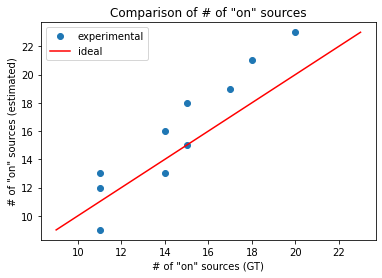

In [7]:
# plot for all entries
a = np.sum(vis_gt, 1)
b = np.sum(v_reconst, 1)
min_err = min(np.min(a), np.min(b))
max_err = max(np.max(a), np.max(b))
x = np.linspace(min_err, max_err); y = x
plt.figure()
plt.plot(a, b, 'o')
plt.plot(x, y, 'r')
plt.legend(['experimental', 'ideal'])
plt.xlabel('# of "on" sources (GT)')
plt.ylabel('# of "on" sources (estimated)')
plt.title('Comparison of # of "on" sources')

In [8]:
np.mean(np.abs(a-b))

1.9

Text(0.5, 1.0, '# of "on" Sources (Only For Misclassified Entries)')

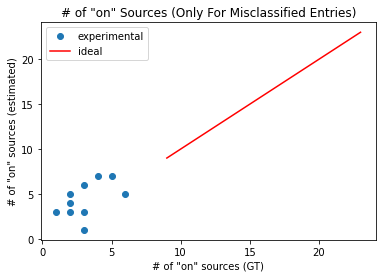

In [9]:
# plot for only misclassified entries
diff = np.abs(vis_gt - v_reconst)
vis_gt_err = vis_gt * diff
v_reconst_err = v_reconst * diff
a_err = np.sum(vis_gt_err, 1)
b_err = np.sum(v_reconst_err, 1)
min_err = min(np.min(a_err), np.min(b_err))
max_err = max(np.max(a_err), np.max(b_err))
x_err = np.linspace(min_err, max_err); y_err = x_err
plt.figure()
plt.plot(a_err, b_err, 'o')
plt.plot(x, y, 'r')
plt.legend(['experimental', 'ideal'])
plt.xlabel('# of "on" sources (GT)')
plt.ylabel('# of "on" sources (estimated)')
plt.title('# of "on" Sources (Only For Misclassified Entries)')

In [10]:
np.mean(np.abs(a_err-b_err))

1.9

In [11]:
# ############## SWEEP NUMBER OF SPOTS ##################
# errors = [];
# for i in range(5, 6):
#     # constant parameters
#     c = 3E8;
    
#     # laser parameters
#     pulseWidth = 1E-9; # must be larger than detector resolution
#     numSpots = i;
#     las_x = np.linspace(0.5, 1.5, numSpots);
#     las_y = 2-las_x; # illumination wall 
    
#     # detector parameters
#     detectorRes = 300E-12; 
#     numPixels = 10;
#     det_x = np.linspace(-1.5, -0.5, numPixels);
#     det_y = 2+det_x; # detector wall
    
#     # miscellaneous parameters
#     maxDist = 3 * (np.max(det_x)**2 + np.max(det_y))**2;
#     vis_gt = np.where(np.random.rand(numPixels, numSpots) > 0.5, 1, 0);
#     numBins = np.ceil(((maxDist+2)/c) / detectorRes).astype(int);
#     t = np.linspace(0, detectorRes * numBins, numBins);
#     plotDat = 1
    
#     # calculate histograms
#     observations, hists = generateData(las_x, las_y, det_x, det_y, numSpots, numPixels, 
#                  vis_gt, numBins, plotDat, 'rect', pulseWidth, t)
#     # compute visibility matrix via gradient descent
# #     v_reconst = inverse(observations, hists, numPixels, numSpots, numBins);